In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from numba import njit
from glob import glob
import momlevel
from xhistogram.xarray import histogram
import julian
import datetime
import cftime

import warnings
warnings.filterwarnings('ignore')

In [2]:
run_dict = {
 'odiv2odiv2_ssp585_rec' :   {
                             'legend_label' : "CM4.0 hist+SSP5-85",
                             'color_identifier' : 'c',
                             },
     'odiv231odiv232_rec' : {
                             'color_identifier' : 'black',
                             'legend_label' : 'CM4X-p25 hist + SSP5-85',
                             },
        'odiv255odiv293_rec' : {
                             'color_identifier' : 'red',
                             'legend_label' : 'CM4X-p125 hist + SSP5-85',
                             },
 'odiv1_300_649_tunits_shift' :   {
                             'legend_label' : "CM4.0 piControl",
                             'color_identifier' : 'yellow',
                             },
 'odiv306_340_689_tunits_shift2' : {
                             'color_identifier' : 'g',
                             'legend_label' : 'CM4X-p25 piControl',
                             },
'odiv209_1_100odiv313_tunits_shift' : {
                             'color_identifier' : 'blue',
                             'legend_label' : 'CM4X-p125 piControl',
                             },
         }

In [3]:
plt.rcParams.update({"font.size":12})
figsize=[6.5,4.0]
savefig_kws=dict(bbox_inches="tight", facecolor="white", dpi=400, format='jpeg')
degC= "$^{\circ}$C"

In [4]:
# Use the same font as JAMES
dirstix = "/net2/rnd/dev/stixfonts/fonts/static_ttf"
import matplotlib.font_manager as font_manager
for font in font_manager.findSystemFonts(dirstix):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'STIX Two Text'

## Read netcdf data and plot Overturning figures:

mean of odiv1_300_649_tunits_shift = [17.939201]
Std of odiv1_300_649_tunits_shift = [1.042604]
mean of odiv306_340_689_tunits_shift2 = [17.15967]
Std of odiv306_340_689_tunits_shift2 = [0.9405439]
mean of odiv209_1_100odiv313_tunits_shift = [16.733885]
Std of odiv209_1_100odiv313_tunits_shift = [0.98570156]
mean of odiv2odiv2_ssp585_rec = [16.26419]
Std of odiv2odiv2_ssp585_rec = [3.2091577]
mean of odiv231odiv232_rec = [14.903621]
Std of odiv231odiv232_rec = [2.7777936]
mean of odiv255odiv293_rec = [14.5552635]
Std of odiv255odiv293_rec = [3.078831]


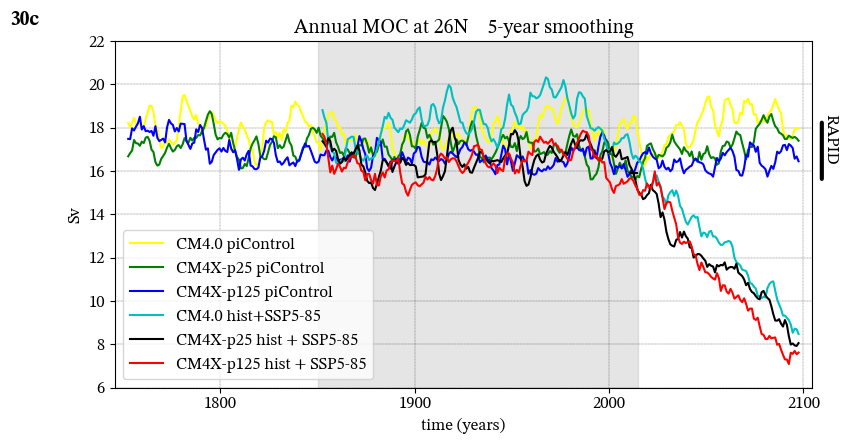

In [5]:
smoothing_level=5   #in years
historical_runs=['odiv1_300_649_tunits_shift','odiv306_340_689_tunits_shift2','odiv209_1_100odiv313_tunits_shift','odiv2odiv2_ssp585_rec','odiv231odiv232_rec','odiv255odiv293_rec']
min_AMOC_depth_constraint=500
obs_label_timedelta=10

fig = plt.figure(figsize=(9,4.5))
start_dates=[]
end_dates=[]
loopnum=0
for keys in historical_runs:
    moc_z_resid=xr.open_dataset("/home/Bill.Hurlin/Matthew.Thomas/python_code/python_scripts/CM4hires_figures/AMOC_RAPID_data/"+"moc_z_resid_"+keys+".nc")
    moc_z_resid_ts=(moc_z_resid.vmo.where(moc_z_resid.z_l>min_AMOC_depth_constraint).max(dim='z_l')/1035/1e6)
#    moc_z_resid_ts.plot(color=run_dict[keys]['color_identifier'],alpha=0.7,linewidth=.5)
    moc_z_resid_ts.rolling(time=smoothing_level,center=True).mean().plot(label=run_dict[keys]['legend_label'],ylim=[6,22],xlim=[1750,2100],color=run_dict[keys]['color_identifier'])
    
    start_dates.append(moc_z_resid.time.values[0])
    end_dates.append(moc_z_resid.time.values[-1])

    print("mean of "+keys+" =",moc_z_resid_ts.mean('time').values)
    print("Std of "+keys+" =",moc_z_resid_ts.std('time').values)
    loopnum+=1

RAPID_transports_annual=xr.open_dataset("/home/Bill.Hurlin/Matthew.Thomas/python_code/python_scripts/CM4hires_figures/AMOC_RAPID_data/RAPID_transports_annual.nc")
outside_fig_date=np.max(end_dates)+datetime.timedelta(weeks = 52*obs_label_timedelta)
# plt.plot([outside_fig_date,outside_fig_date],[RAPID_transports_annual.moc_mar_hc10.mean()-RAPID_transports_annual.moc_mar_hc10.std(),RAPID_transports_annual.moc_mar_hc10.mean()+RAPID_transports_annual.moc_mar_hc10.std()],color="k",linewidth=3,clip_on=False)
plt.annotate('',xy=(outside_fig_date,RAPID_transports_annual.moc_mar_hc10.mean()-RAPID_transports_annual.moc_mar_hc10.std()), xytext=(outside_fig_date,RAPID_transports_annual.moc_mar_hc10.mean()+RAPID_transports_annual.moc_mar_hc10.std()),arrowprops=dict(arrowstyle="-",color='k',linewidth=3),annotation_clip=False)
#plt.fill_between([np.min(start_dates),np.max(end_dates)],RAPID_transports_annual.moc_mar_hc10.mean()-RAPID_transports_annual.moc_mar_hc10.std(),RAPID_transports_annual.moc_mar_hc10.mean()+RAPID_transports_annual.moc_mar_hc10.std(), alpha=0.2, label='annual obs (mean+/-std)')
text=plt.annotate('RAPID',xy=(outside_fig_date,16.5), xytext=(outside_fig_date,16.5),annotation_clip=False)
text.set_rotation(270)
plt.xlabel('time (years)')
plt.ylabel('Sv')
plt.title('Annual MOC at 26N    '+str(smoothing_level)+'-year smoothing')
plt.xlim([np.min(start_dates)-datetime.timedelta(weeks = 52*5),np.max(end_dates)+datetime.timedelta(weeks = 52*5)])
plt.legend(loc="lower left")
plt.grid(color='black', linestyle='--', linewidth=.2)
plt.fill_between([cftime.DatetimeNoLeap(1850,1,1),cftime.DatetimeNoLeap(2015,1,1)],6,22,alpha=0.2, color='gray',label='historical')
text=plt.annotate('30c', xy=(-.15, 1.09),xycoords='axes fraction', ha='left', va='top',fontsize=14, color='black',fontweight='bold')
#plt.savefig('Fig_11_AMOC_RAPID_grayshade.jpeg',**savefig_kws)

In [ ]:
#end of notebook